# Import Packages

In [184]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [185]:
pd.reset_option("display.max_columns", None)

# Import Data

In [2]:
events = pd.read_csv("epl_event_data_15.csv")

# Target Label Creation

-> 1 if player wins a foul after recieving or recovering the ball during possession, else 0

In [3]:
def create_target_labels(events_df):
    # Filter to events that start a possession
    start_events = events_df[events_df["type.name"].isin(["Ball Receipt*", "Ball Recovery"])].copy()
    
    # Minimal view for lookup
    events_core = events_df[["player.id", "player.name", "player_possession", "type.name"]]
    
    # All foul won events
    foul_events = events_core[events_core["type.name"] == "Foul Won"]
    foul_lookup = foul_events.groupby(["player_possession", "player.id"]).size().reset_index(name="foul_count")
    
    # Merge with start events
    start_events["target_foul_won"] = start_events.merge(
        foul_lookup,
        how="left",
        on=["player_possession", "player.id"]
    )["foul_count"].fillna(0).astype(int)
    
    # Convert to binary label
    start_events["target_foul_won"] = start_events["target_foul_won"].apply(lambda x: 1 if x > 0 else 0)
    
    return start_events

In [4]:
labelled_df = create_target_labels(events)
labelled_df.head()

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,...,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id,target_foul_won
5,1f98c89e-2326-4200-8c12-a987fdbbaf2e,6,1,00:00:02.061,0,2,2,6,NaN,2ca23eea-a984-47e4-8243-8f00880ad1c9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058,0
8,8764f645-0544-426e-9bef-764dcf13f019,9,1,00:00:03.010,0,3,2,7,NaN,0fee7719-7e69-49c5-be81-3f2b77da604e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058,0
10,4e43a985-9566-4762-868f-c992de243bd6,11,1,00:00:05.465,0,5,2,8,NaN,6362aa69-892f-4d11-8644-21a680ea7c66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058,0
13,a4eb31c9-6417-4a65-9f71-b3aeece1758e,14,1,00:00:07.941,0,7,2,9,NaN,56da36e4-8b0d-4596-ba46-1d944c3d3f04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058,0
16,4b427f4b-296d-4967-a419-b6b480fe50e2,17,1,00:00:10.462,0,10,2,10,NaN,bcfea2e3-9736-4975-be28-ef2c9d693fa7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058,0


In [6]:
labelled_df.target_foul_won.value_counts(normalize=True)

target_foul_won
0    0.992326
1    0.007674
Name: proportion, dtype: float64

* Highly imbalanced label, we might have to under-sample the majority class.
* Yet, this reflects the real world scenario, a player winning a foul after recieving or recovering the ball is rare

# Feature Pipeline

In [175]:
def extract_location_features(df):
    """
        * Extracts x, y location from the location feature
        * Calculates distance to goal
        * Identifies which zone of the field the player is in
    """
    df = df.copy()
    df[["location_x", "location_y"]] = df["location"].apply(
        lambda loc: pd.Series([float(i.strip()) for i in loc.split(",")] if isinstance(loc, str) and "," in loc else [np.nan, np.nan])
    )
    df["dist_to_goal"] = ((120 - df["location_x"])**2 + (40 - df["location_y"])**2)**0.5
    df["third"] = pd.cut(df["location_x"], bins=[-1, 40, 80, 120], labels=["Defensive", "Midfield", "Attacking"])
    df["side"] = pd.cut(df["location_y"], bins=[-1, 26.6, 53.3, 80], labels=["Left", "Center", "Right"])
    return df

def compute_possession_aggregates(events_df):
    df = events_df[[
        "player_possession", "type.name",
        "pass.length", "pass.outcome.name", "pass.angle",
        "pass.height.name", "pass.body_part.name",
        "dribble.outcome.name", "duel.outcome.name",
        "minute"
    ]].copy()

    agg = df.groupby("player_possession").agg(
        n_events=("type.name", "count"),
        n_passes=("type.name", lambda x: (x == "Pass").sum()),
        n_carries=("type.name", lambda x: (x == "Carry").sum()),
        n_duels=("type.name", lambda x: (x == "Duel").sum()),
        n_dribbles=("type.name", lambda x: (x == "Dribble").sum()),
        n_dispossessed=("type.name", lambda x: (x == "Dispossessed").sum()),
        
        avg_pass_length=("pass.length", "mean"),
        max_pass_length=("pass.length", "max"),
        avg_pass_angle=("pass.angle", "mean"),
        std_pass_angle=("pass.angle", "std"),
        
        n_successful_passes=("pass.outcome.name", lambda x: x.isnull().sum()),
        n_failed_passes=("pass.outcome.name", lambda x: x.notnull().sum()),
        
        n_successful_dribbles=("dribble.outcome.name", lambda x: (x == "Complete").sum()),
        n_failed_dribbles=("dribble.outcome.name", lambda x: x.notnull().sum() - (x == "Complete").sum()),
        
        n_duel_wins=("duel.outcome.name", lambda x: (x == "Won").sum()),
        n_duel_losses=("duel.outcome.name", lambda x: (x == "Lost").sum()),
        
        poss_start_minute=("minute", "min"),
        poss_end_minute=("minute", "max")
    ).reset_index()

    agg["poss_duration"] = agg["poss_end_minute"] - agg["poss_start_minute"]

    # Mode-based categorical aggregations
    mode_pass_info = df[df["type.name"] == "Pass"].groupby("player_possession").agg(
        mode_pass_height=("pass.height.name", lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown"),
        mode_body_part=("pass.body_part.name", lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown")
    ).reset_index()

    return agg.merge(mode_pass_info, on="player_possession", how="left")

def target_creation(events_df):
    foul_events = events_df[events_df["type.name"] == "Foul Won"]
    foul_lookup = foul_events.groupby(["player_possession", "player.id"]).size().reset_index(name="foul_count")
    
    start_events["target_foul_won"] = start_events.merge(
        foul_lookup,
        how="left",
        on=["player_possession", "player.id"]
    )["foul_count"].fillna(0).astype(int).apply(lambda x: 1 if x > 0 else 0)
    y = start_events["target_foul_won"]
    return y

In [188]:
foul_events = events[events["type.name"] == "Foul Won"]
pd.set_option('display.max_columns', None)
foul_events.head()

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,location,under_pressure,counterpress,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,player.id,player.name,position.id,position.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,pass.outcome.id,pass.outcome.name,pass.receipient.id,pass.recipient.name,pass.end_location,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id
304,e2b23fc3-7012-4a52-b1f9-05c7fbed63e7,305,1,00:05:48.686,5,48,13,122,0.0,d3628ab0-f089-41a5-bbeb-3c00887594d5,"22.3, 76.7",True,NaN,21,Foul Won,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3049.0,Matt Ritchie,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
384,73aaf4ac-139d-47dc-a0e6-3066d103b06b,385,1,00:08:14.319,8,14,14,155,0.0,ae4bc28c-f526-488b-9f16-bd858966a264,"65.7, 26.1",True,NaN,21,Foul Won,28,AFC Bournemouth,4,From Throw In,28,AFC Bournemouth,NaN,NaN,3346.0,Joshua King,23.0,Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
645,dc660f42-07f9-422a-ae25-289a553c9376,646,1,00:14:40.290,14,40,24,259,0.0,"2b5c24dd-65cd-47ec-b712-b36e97ec6600, 5b1aac7c...","81.6, 18.5",True,NaN,21,Foul Won,22,Leicester City,1,Regular Play,22,Leicester City,NaN,NaN,3307.0,Marc Albrighton,16.0,Left Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
852,61b87943-22ed-42fa-b41d-b569ad703eb5,853,1,00:19:45.731,19,45,36,356,0.0,"28544a98-b437-4e2b-a462-5b7ebe02cd51, 9a779e6b...","73.8, 63.7",True,NaN,21,Foul Won,28,AFC Bournemouth,4,From Throw In,28,AFC Bournemouth,NaN,NaN,3344.0,Andrew Surman,10.0,Center Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
897,c9320f87-df13-473e-9ef9-3922af783665,898,1,00:20:48.697,20,48,38,378,0.0,4bef9249-39b1-424c-8896-58acadb2aff5,"63.2, 54.9",NaN,NaN,21,Foul Won,22,Leicester City,4,From Throw In,22,Leicester City,NaN,NaN,3671.0,José Leonardo Ulloa,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058


In [190]:
pd.set_option('display.max_rows', None)
events[(events['match_id']==3754058) & (events['possession']==13)]

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,location,under_pressure,counterpress,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,player.id,player.name,position.id,position.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,pass.outcome.id,pass.outcome.name,pass.receipient.id,pass.recipient.name,pass.end_location,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id
302,42642a37-aa29-4eee-b805-97f8e182a4ec,303,1,00:05:46.262,5,46,13,122,0.000000,NaN,"18.9, 77",NaN,NaN,2,Ball Recovery,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3049.0,Matt Ritchie,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
303,d3628ab0-f089-41a5-bbeb-3c00887594d5,304,1,00:05:48.686,5,48,13,122,0.000000,e2b23fc3-7012-4a52-b1f9-05c7fbed63e7,"97.8, 3.4",NaN,NaN,22,Foul Committed,28,AFC Bournemouth,1,Regular Play,22,Leicester City,NaN,NaN,3812.0,Christian Fuchs,6.0,Left Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
304,e2b23fc3-7012-4a52-b1f9-05c7fbed63e7,305,1,00:05:48.686,5,48,13,122,0.000000,d3628ab0-f089-41a5-bbeb-3c00887594d5,"22.3, 76.7",True,NaN,21,Foul Won,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3049.0,Matt Ritchie,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
305,65794d04-a58b-4318-96e8-37ab88214520,306,1,00:05:48.942,5,48,13,122,0.799999,4f657863-3864-4cf6-9ec0-e05efac3d793,"23.6, 77.2",NaN,NaN,30,Pass,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3049.0,Matt Ritchie,12.0,Right Midfield,9.726768,-1.310856,1.0,Ground Pass,40.0,Right Foot,NaN,NaN,NaN,NaN,NaN,Andrew Surman,"26.1, 67.8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
306,4f657863-3864-4cf6-9ec0-e05efac3d793,307,1,00:05:49.742,5,49,13,123,NaN,65794d04-a58b-4318-96e8-37ab88214520,"26.1, 67.8",NaN,NaN,42,Ball Receipt*,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3344.0,Andrew Surman,10.0,Center Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
307,ccd13766-0dba-4091-8f81-40b6b776def5,308,1,00:05:54.309,5,54,13,123,1.990906,"029382bc-7616-4beb-9b47-e5a9f6c63917, 93a14201...","96.7, 17.3",NaN,NaN,17,Pressure,28,AFC Bournemouth,1,Regular Play,22,Leicester City,NaN,NaN,10960.0,Jamie Vardy,24.0,Left Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
308,a8072acb-326a-48ca-854c-2dad8aa8ccf8,309,1,00:05:54.898,5,54,13,123,1.361715,"029382bc-7616-4beb-9b47-e5a9f6c63917, ccd13766...","20.1, 64",True,NaN,30,Pass,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3344.0,Andrew Surman,10.0,Center Defensive Midfield,8.702298,1.547812,1.0,Ground Pass,40.0,Right Foot,NaN,NaN,NaN,NaN,NaN,Simon Francis,"20.3, 72.7",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
309,029382bc-7616-4beb-9b47-e5a9f6c63917,310,1,00:05:56.260,5,56,13,124,NaN,"a8072acb-326a-48ca-854c-2dad8aa8ccf8, ccd13766...","20.3, 72.7",True,NaN,42,Ball Receipt*,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3608.0,Simon Francis,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
310,93a14201-88d3-4ba0-97c3-eda13dbac0e6,311,1,00:05:56.260,5,56,13,124,2.863985,"06b26a07-5daf-466b-9c82-242455b90a64, 346678b0...","20.3, 72.7",True,NaN,30,Pass,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3608.0,Simon Francis,3.0,Right Center Back,54.456770,-0.429971,3.0,High Pass,40.0,Right Foot,NaN,NaN,9.0,Incomplete,NaN,Joshua King,"69.8, 50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
311,ea7d65ce-c214-4347-b862-

In [144]:
def build_training_dataset(events_df):
    # Step 1: Label creation
    start_events = events_df[events_df["type.name"].isin(["Ball Receipt*", "Ball Recovery"])].copy()

    # Step 2: Feature enrichment
    start_events = extract_location_features(start_events)
    start_events["under_pressure"] = start_events["under_pressure"].notnull().astype(int)

    # Step 3: Merge aggregated features
    possession_agg = compute_possession_aggregates(events_df)
    start_events = start_events.merge(possession_agg, how="left", on="player_possession")

    # Step 4: Encode categorical features
    label_cols = ["team.name", "player.name", "third", "side", "mode_pass_height", "mode_body_part"]
    for col in label_cols:
        if col in start_events.columns:
            start_events[col] = start_events[col].astype(str).fillna("Unknown")
            le = LabelEncoder()
            start_events[col] = le.fit_transform(start_events[col])

    # Step 5: Select final features
    feature_cols = [
        "minute", "period", "under_pressure",
        # "location_x", "location_y",
        "dist_to_goal",
        "third", "side",
        # "team.name", "player.name",

        # Possession-level aggregates
        "n_events", "n_passes", "n_carries", "n_duels", "n_dribbles", "n_dispossessed",
        "avg_pass_length", "max_pass_length",
        "avg_pass_angle", "std_pass_angle",
        "n_successful_passes", "n_failed_passes",
        "n_successful_dribbles", "n_failed_dribbles",
        "n_duel_wins", "n_duel_losses",
        "poss_duration",
        "mode_pass_height", "mode_body_part"
    ]
    foul_events = events_df[events_df["type.name"] == "Foul Won"]
    foul_lookup = foul_events.groupby(["player_possession", "player.id"]).size().reset_index(name="foul_count")
    
    start_events["target_foul_won"] = start_events.merge(
        foul_lookup,
        how="left",
        on=["player_possession", "player.id"]
    )["foul_count"].fillna(0).astype(int).apply(lambda x: 1 if x > 0 else 0)
    available_features = [f for f in feature_cols if f in start_events.columns]
    X = start_events[available_features]
    y = start_events["target_foul_won"]

    # Step 6: Return identifiers for traceability
    identifiers = start_events[["id", "match_id", "player.id", "team.id", "player_possession"]].reset_index(drop=True)
    return X.reset_index(drop=True), y.reset_index(drop=True), identifiers

In [145]:
X, y, identifiers = build_training_dataset(events)

In [40]:
X.head(15)

,minute,period,under_pressure,location_x,location_y,dist_to_goal,third,side,team.name,player.name,...,std_pass_angle,n_successful_passes,n_failed_passes,n_successful_dribbles,n_failed_dribbles,n_duel_wins,n_duel_losses,poss_duration,mode_pass_height,mode_body_part
0,0,1,0,60.4,43.6,59.708626,2,0,0,276,...,2.514629,1042,17,0,0,0,0,0,0,3
1,0,1,0,48.0,41.7,72.020067,2,0,0,37,...,1.683317,1046,98,0,2,0,0,0,0,3
2,0,1,0,37.5,76.1,90.052540,1,2,0,8,...,1.580563,888,63,6,0,1,0,0,0,3
3,0,1,0,27.4,58.1,94.352371,1,2,0,473,...,1.515100,808,91,4,2,1,0,0,0,3
4,0,1,0,35.1,77.8,92.934654,1,2,0,8,...,1.532644,771,79,4,2,0,0,1,0,3
5,0,1,0,16.7,75.5,109.229758,1,2,0,473,...,1.506698,809,63,2,4,0,0,1,0,3
6,0,1,0,20.1,29.3,100.471389,1,0,0,477,...,1.469560,821,80,4,5,4,0,1,0,3
7,0,1,0,41.8,4.7,85.798193,2,1,0,84,...,1.545731,796,81,4,4,3,0,1,0,3
8,0,1,0,22.5,16.4,100.315552,1,1,0,477,...,1.593946,815,56,4,11,5,0,1,0,3
9,0,1,0,20.4,52.4,100.368919,1,0,0,473,...,1.642876,835,72,4,4,3,0,2,0,3


In [41]:
X.columns

Index(['minute', 'period', 'under_pressure', 'location_x', 'location_y',
       'dist_to_goal', 'third', 'side', 'team.name', 'player.name', 'n_events',
       'n_passes', 'n_carries', 'n_duels', 'n_dribbles', 'n_dispossessed',
       'avg_pass_length', 'max_pass_length', 'avg_pass_angle',
       'std_pass_angle', 'n_successful_passes', 'n_failed_passes',
       'n_successful_dribbles', 'n_failed_dribbles', 'n_duel_wins',
       'n_duel_losses', 'poss_duration', 'mode_pass_height', 'mode_body_part'],
      dtype='object')

In [19]:
identifiers.head()

,id,match_id,player.id,team.id,player_possession
0,1f98c89e-2326-4200-8c12-a987fdbbaf2e,3754058,3346.0,28,6
1,8764f645-0544-426e-9bef-764dcf13f019,3754058,3344.0,28,7
2,4e43a985-9566-4762-868f-c992de243bd6,3754058,6409.0,28,8
3,a4eb31c9-6417-4a65-9f71-b3aeece1758e,3754058,3608.0,28,9
4,4b427f4b-296d-4967-a419-b6b480fe50e2,3754058,6409.0,28,10


In [25]:
events.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

In [33]:
events.location.unique()

array([nan, '61, 40.1', '60.4, 43.6', ..., '55.1, 57.9', '52.5, 57',
       '44.5, 73.5'], dtype=object)

In [26]:
events[(events.match_id==3754058) & (events.player_possession == 6)][['location', 'type.name','pass.length']]

,location,type.name,pass.length
5,"60.4, 43.6",Ball Receipt*,NaN
6,"60.4, 43.6",Carry,NaN
7,"60.4, 43.6",Pass,12.54472


In [14]:
X.columns

Index(['minute', 'period', 'under_pressure', 'location_x', 'location_y',
       'dist_to_goal', 'third', 'side', 'pass.length', 'pass.angle',
       'pass.height.name', 'pass.body_part.name', 'pass.outcome.name',
       'team.name', 'player.name', 'n_events', 'n_passes', 'n_carries',
       'n_duels', 'n_dribbles', 'n_dispossessed', 'avg_pass_length',
       'max_pass_length', 'n_successful_passes', 'n_failed_passes',
       'n_successful_dribbles', 'n_failed_dribbles', 'n_duel_wins',
       'n_duel_losses', 'poss_duration'],
      dtype='object')

# Baseline Model

In [44]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, f1_score, classification_report
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_foul_prediction_model(X, y, test_size=0.25, random_state=42):
    # 1. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # # 2. Handle class imbalance
    # scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # 3. LightGBM training
    model = lgb.LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        # scale_pos_weight=scale_pos_weight,
        n_estimators=250,
        random_state=random_state,
        class_weight=None,
        learning_rate=0.05
    )

    model.fit(X_train, y_train)

    # 4. Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 5. Evaluate
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC:  {pr_auc:.4f}")

    # 8. Feature importance
    feature_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_imp.head(20))
    plt.title("Top 20 Feature Importances")
    plt.show()

    return model, X_test, y_test, y_pred_proba

def plot_precision_recall_curve(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

[LightGBM] [Info] Number of positive: 7285, number of negative: 278665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 285950, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025476 -> initscore=-3.644193
[LightGBM] [Info] Start training from score -3.644193
ROC AUC: 0.6543
PR AUC:  0.0550


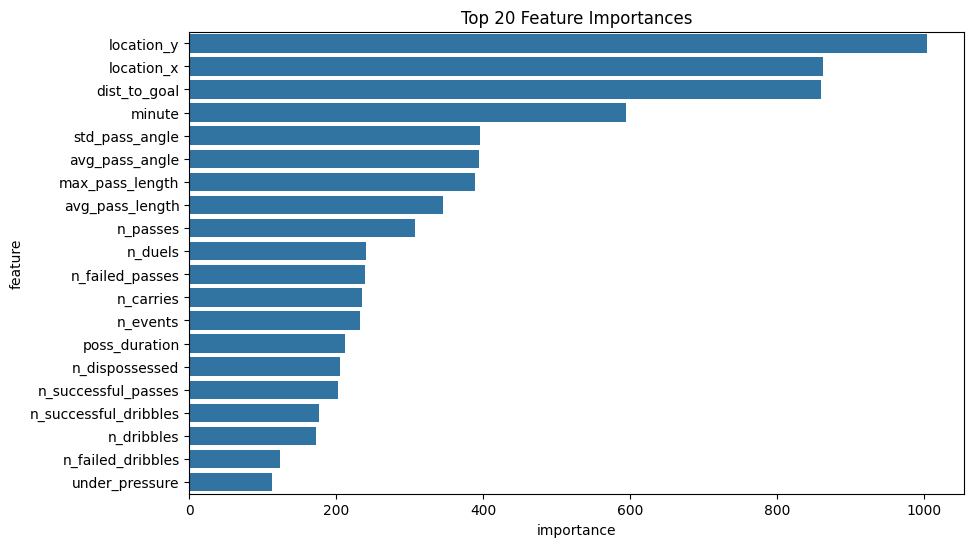

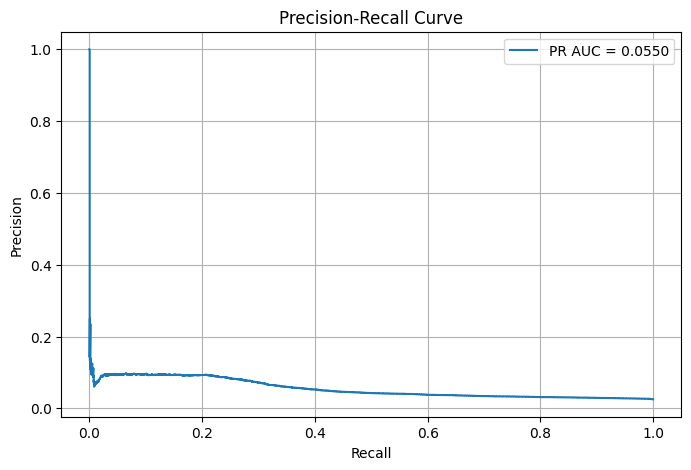

In [75]:
model, X_test, y_test, y_proba = train_foul_prediction_model(X, y)
plot_precision_recall_curve(y_test, y_proba)

In [47]:
X[y.isnull()]

,minute,period,under_pressure,location_x,location_y,dist_to_goal,third,side,team.name,player.name,...,std_pass_angle,n_successful_passes,n_failed_passes,n_successful_dribbles,n_failed_dribbles,n_duel_wins,n_duel_losses,poss_duration,mode_pass_height,mode_body_part
110988,45,1,0,55.0,52.2,66.135013,2,0,15,209,...,1.600584,828,61,2,3,1,0,52,0,3
110989,45,1,0,34.5,59.6,87.717786,1,2,15,156,...,1.586082,781,58,3,1,4,0,16,0,3
110990,0,1,0,36.9,30.2,83.675863,1,0,15,46,...,1.523739,791,57,3,4,0,0,52,0,3
110991,45,2,0,60.4,35.5,59.769641,2,0,15,190,...,1.584192,823,68,8,4,4,0,53,0,3
110992,45,2,0,55.5,38.2,64.525111,2,0,15,260,...,1.511693,828,41,3,3,2,0,16,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381262,94,2,0,50.7,58.7,71.778688,2,2,3,139,...,1.529571,604,41,4,3,1,0,24,0,3
381263,94,2,0,53.9,65.6,70.884201,2,2,3,424,...,1.449841,615,43,4,4,0,0,24,0,3
381264,94,2,0,62.6,9.1,65.188726,2,1,15,39,...,1.412241,601,39,3,0,1,0,24,0,3
381265,94,2,0,73.2,6.6,57.496087,2,1,15,546,...,1.586436,630,41,5,5,0,0,24,0,3


In [58]:
y[y.isnull()].shape

(0,)

In [52]:
y[300000:]

300000   NaN
300001   NaN
300002   NaN
300003   NaN
300004   NaN
          ..
381262   NaN
381263   NaN
381264   NaN
381265   NaN
381266   NaN
Name: target_foul_won, Length: 81267, dtype: float64

In [59]:
y.value_counts()

target_foul_won
0    371553
1      9714
Name: count, dtype: int64

In [55]:
y.shape

(381267,)

In [53]:
X[300000:]

,minute,period,under_pressure,location_x,location_y,dist_to_goal,third,side,team.name,player.name,...,std_pass_angle,n_successful_passes,n_failed_passes,n_successful_dribbles,n_failed_dribbles,n_duel_wins,n_duel_losses,poss_duration,mode_pass_height,mode_body_part
300000,4,1,0,72.8,77.8,60.470489,2,2,9,289,...,1.556343,843,58,3,10,5,0,6,0,3
300001,5,1,0,63.9,11.1,63.106418,2,1,11,434,...,1.525749,857,66,7,2,4,0,6,0,3
300002,5,1,0,39.8,48.8,80.681349,1,0,9,370,...,1.538593,806,60,3,1,3,0,6,0,3
300003,5,1,0,43.7,14.6,80.416727,2,1,9,155,...,1.578898,824,60,6,2,4,0,5,0,3
300004,5,1,0,66.6,25.3,55.386370,2,1,9,237,...,1.512733,879,54,4,1,2,0,5,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381262,94,2,0,50.7,58.7,71.778688,2,2,3,139,...,1.529571,604,41,4,3,1,0,24,0,3
381263,94,2,0,53.9,65.6,70.884201,2,2,3,424,...,1.449841,615,43,4,4,0,0,24,0,3
381264,94,2,0,62.6,9.1,65.188726,2,1,15,39,...,1.412241,601,39,3,0,1,0,24,0,3
381265,94,2,0,73.2,6.6,57.496087,2,1,15,546,...,1.586436,630,41,5,5,0,0,24,0,3


# RF Model

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report, f1_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def train_random_forest(X, y, test_size=0.25, random_state=42):
    # Drop NaNs if needed
    mask = y.notnull()
    X = X[mask]
    y = y[mask]
    
    # 1. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )
    
    # 2. Train Random Forest with class_weight to handle imbalance
    rf = RandomForestClassifier(
        n_estimators=120,
        max_depth=12,
        min_samples_split=4,
        min_samples_leaf=3,
        criterion='entropy',
        random_state=random_state,
        # class_weight="balanced",  # handles imbalance by weighing classes inversely
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    
    # 3. Predict probabilities
    test_y_pred_proba = rf.predict_proba(X_test)[:, 1]
    train_y_pred_proba = rf.predict_proba(X_train)[:, 1]
    # 4. Evaluation
    train_roc_auc = roc_auc_score(y_train, train_y_pred_proba)
    test_roc_auc = roc_auc_score(y_test, test_y_pred_proba)
    precision, recall, thresholds = precision_recall_curve(y_train, train_y_pred_proba)
    train_pr_auc = auc(recall, precision)
    precision, recall, thresholds = precision_recall_curve(y_test, test_y_pred_proba)
    test_pr_auc = auc(recall, precision)
    
    print(f"Random Forest ROC AUC: Train={train_roc_auc:.4f}, Test={test_roc_auc:.4f}")
    print(f"Random Forest PR AUC:  Train={train_pr_auc:.4f}, Test={test_pr_auc:.4f}")
    
    # 6. Feature importances
    feature_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": rf.feature_importances_
    }).sort_values("importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_imp.head(20))
    plt.title("Top 20 Feature Importances (RF)")
    plt.show()
    
    return rf, X_test, y_test, train_y_pred_proba, test_y_pred_proba

In [131]:
def thresholding(y_pred_proba, y_test, threshold):
    # Optional threshold tuning
    # threshold = 0.3
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print("\nClassification Report (threshold=0.3):")
    print(classification_report(y_test, y_pred))
    
    # 5. Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
    plt.title("Confusion Matrix (Random Forest)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Random Forest ROC AUC: Train=0.8195, Test=0.6553
Random Forest PR AUC:  Train=0.1937, Test=0.0549


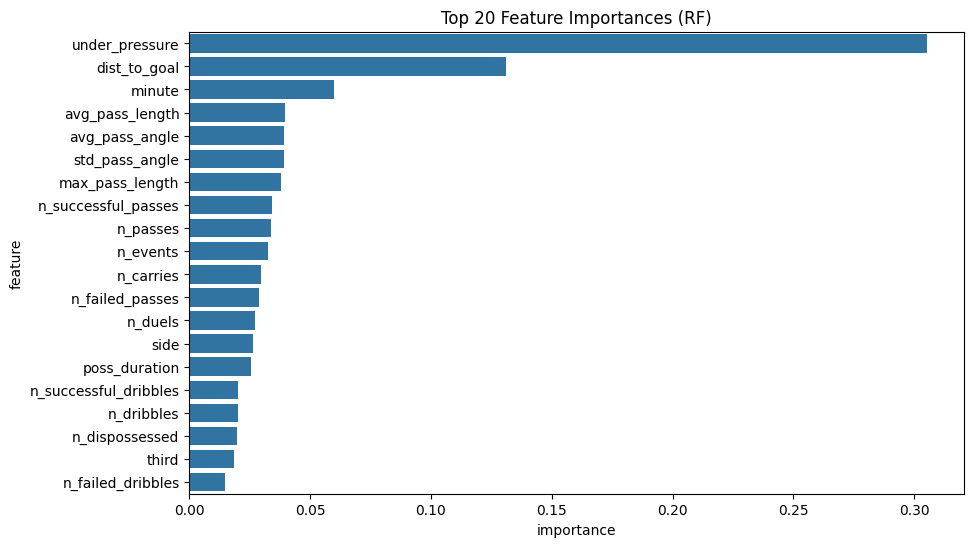

In [172]:
rf_model, X_test_rf, y_test_rf, train_y_proba_rf, test_y_proba_rf = train_random_forest(X, y)

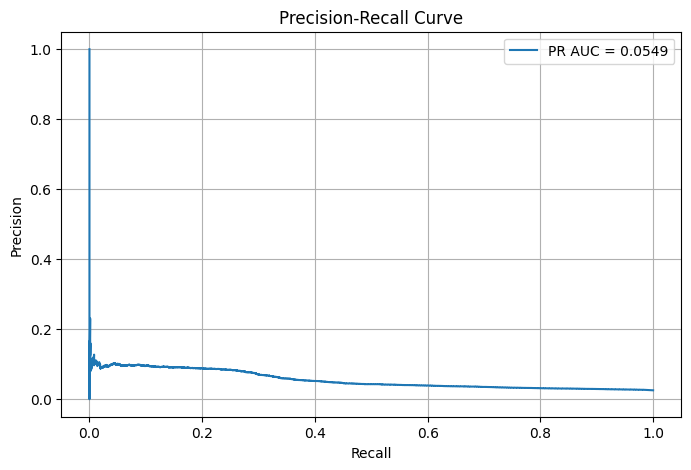

In [173]:
plot_precision_recall_curve(y_test, test_y_proba_rf)


Classification Report (threshold=0.3):
              precision    recall  f1-score   support

           0       0.98      0.50      0.67     92888
           1       0.03      0.64      0.06      2429

    accuracy                           0.51     95317
   macro avg       0.51      0.57      0.36     95317
weighted avg       0.96      0.51      0.65     95317



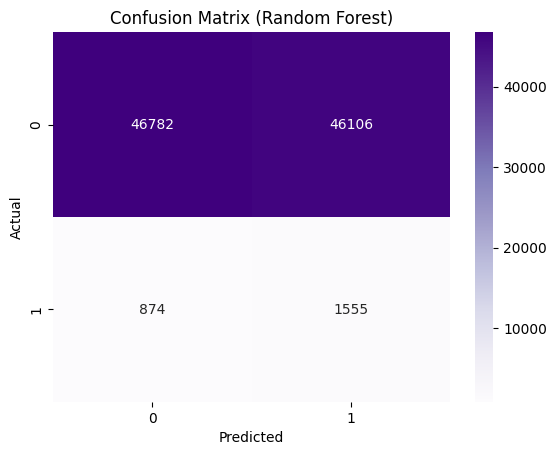

In [174]:
threshold = 0.005
thresholding(y_proba_rf, y_test_rf, threshold)